In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!mkdir -p hateful_memes
!unzip -q gdrive/MyDrive/data.zip -d /content/hateful_memes/

!pip install --quiet \
    transformers torch torchvision tqdm scikit-learn matplotlib seaborn wandb \
    pillow opencv-python ftfy regex git+https://github.com/openai/CLIP.git \
    albumentations


In [ ]:
import os, json, random, re
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, roc_auc_score
)
from tqdm.notebook import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

MODEL_TYPE = "BLIP"

if MODEL_TYPE == "CLIP":
    import clip
    backbone, _ = clip.load("ViT-B/32", device=device)
    def extract_image_feats(imgs):
        return backbone.encode_image(imgs).float()
    def extract_text_feats(tokens):
        return backbone.encode_text(tokens).float()
    tokenize_fn = lambda texts: clip.tokenize(texts)

elif MODEL_TYPE == "BLIP":
    from transformers import BlipProcessor, BlipModel
    processor = BlipProcessor.from_pretrained(
        "Salesforce/blip-image-captioning-base",
        use_fast=True
    )
    backbone = BlipModel.from_pretrained(
        "Salesforce/blip-image-captioning-base"
    ).to(device)

    def extract_image_feats(imgs):
        pix = processor(
            images=[t.cpu().permute(1,2,0).numpy() for t in imgs],
            return_tensors="pt"
        ).pixel_values.to(device)
        return backbone.get_image_features(pixel_values=pix).float()

    def extract_text_feats(texts):
        enc = processor(
            text=texts, return_tensors="pt", padding=True
        ).to(device)
        return backbone.get_text_features(**enc).float()

    tokenize_fn = None

elif MODEL_TYPE == "SIGLIP":
    from siglip import SigLIPProcessor, SigLIPModel
    processor = SigLIPProcessor.from_pretrained("siglip-base")
    backbone  = SigLIPModel.from_pretrained("siglip-base").to(device)
    def extract_image_feats(imgs):
        enc = processor(
            images=[t.cpu().permute(1,2,0).numpy() for t in imgs],
            return_tensors="pt"
        ).to(device)
        return backbone.get_image_features(**enc).float()
    def extract_text_feats(texts):
        enc = processor(
            text=texts, return_tensors="pt", padding=True
        ).to(device)
        return backbone.get_text_features(**enc).float()
    tokenize_fn = None

else:
    raise ValueError(f"Unknown MODEL_TYPE {MODEL_TYPE}")


In [ ]:
# 1) Lexicon for pseudo‑labels
LEXICON = {
    'racial':    {'slur1':3, 'slur2':3},
    'gender':    {'insult1':1, 'insult2':1},
    'religion':  {'slurA':2, 'slurB':2},
    'political': {'termX':1},
    'other':     {'hate':1}
}
SEVERITY_THRESHOLDS = (2, 5)  # medium>=2, high>=5
SEVERITY_LEVELS   = ['low','medium','high']
HATE_SUBTYPES     = list(LEXICON.keys())

def heuristic_labels(text: str):
    scores = {k:0 for k in LEXICON}
    t = text.lower()
    for subtype, words in LEXICON.items():
        for w, pts in words.items():
            scores[subtype] += t.count(w)*pts
    total = sum(scores.values())
    if   total >= SEVERITY_THRESHOLDS[1]: sev='high'
    elif total >= SEVERITY_THRESHOLDS[0]: sev='medium'
    else: sev='low'
    subs = [s for s,v in scores.items() if v>0]
    return sev, subs

if MODEL_TYPE == "CLIP":
    from clip.simple_tokenizer import SimpleTokenizer
    def safe_tokenize(texts, context_length=77):
        if isinstance(texts,str): texts=[texts]
        try:
            return clip.tokenize(texts, context_length=context_length)
        except RuntimeError:
            tokenizer = SimpleTokenizer()
            sot = tokenizer.encoder["<|startoftext|>"]
            eot = tokenizer.encoder["<|endoftext|>"]
            max_toks = context_length - 2
            res = torch.zeros(len(texts), context_length, dtype=torch.long)
            for i,t in enumerate(texts):
                toks = tokenizer.encode(t)
                toks = toks[:max_toks]
                toks = [sot]+toks+[eot]
                toks = toks[:context_length]
                res[i,:len(toks)] = torch.tensor(toks)
            return res
else:
    def safe_tokenize(texts, context_length=77):
        raise RuntimeError("only for CLIP")

import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE   = 224
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.CoarseDropout(
        num_holes_range=(8, 8),
        hole_height_range=(32, 32),
        hole_width_range=(32, 32),
        p=0.3
    ),
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

DATA_ROOT = "/content/hateful_memes"

class HatefulMemesDataset(Dataset):
    def __init__(self, path, split="train", transform=None, use_heuristic=False):
        self.transform      = transform
        self.use_heuristic  = use_heuristic
        with open(f"{path}/{split}.jsonl") as f:
            self.entries = [json.loads(l) for l in f]

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        e = self.entries[idx]
        img = Image.open(f"{DATA_ROOT}/{e['img']}").convert('RGB')
        img = self.transform(image=np.array(img))['image'] if self.transform else transforms.ToTensor()(img)

        sev_idx, sub_vec = -1, torch.zeros(len(HATE_SUBTYPES))
        if self.use_heuristic and e['label']==1:
            sev, subs = heuristic_labels(e['text'])
            sev_idx = SEVERITY_LEVELS.index(sev)
            for s in subs:
                sub_vec[HATE_SUBTYPES.index(s)] = 1

        return {
            'image':    img,
            'text':     e['text'],
            'label':    torch.tensor(e['label'], dtype=torch.float),
            'severity': torch.tensor(sev_idx,  dtype=torch.long),
            'subtypes': sub_vec
        }

MultilabelHatefulMemesDataset = HatefulMemesDataset


In [ ]:
train_ds = HatefulMemesDataset(
    DATA_ROOT, "train",
    transform=train_transform,
    use_heuristic=True
)
val_ds   = HatefulMemesDataset(
    DATA_ROOT, "dev",
    transform=val_transform,
    use_heuristic=True
)

# Balance hateful vs non-hateful
labels = [int(x['label']) for x in train_ds.entries]
class_counts = np.bincount(labels)
weights = [1.0/class_counts[l] for l in labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

BATCH_SIZE = 32
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE,
    sampler=sampler, num_workers=2, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=2, pin_memory=True
)

print("Train/Val sizes:", len(train_ds), len(val_ds))


Train/Val sizes: 8500 500


In [ ]:
from transformers import get_cosine_schedule_with_warmup

if MODEL_TYPE == "BLIP":
    for name, param in backbone.named_parameters():
        requires = any(x in name for x in ["encoder.layer.10", "encoder.layer.11"])
        param.requires_grad = requires

n_samples = len(train_ds)
n_pos     = sum(int(x['label']) for x in train_ds.entries)
n_neg     = n_samples - n_pos
pos_weight = torch.tensor(n_neg / n_pos).to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, pos_weight=None):
        super().__init__()
        self.alpha      = alpha
        self.gamma      = gamma
        self.pos_weight = pos_weight
    def forward(self, logits, targets):
        bce = F.binary_cross_entropy_with_logits(
            logits, targets, pos_weight=self.pos_weight, reduction='none'
        )
        probs = torch.sigmoid(logits)
        p_t   = probs*targets + (1-probs)*(1-targets)
        focal = (1 - p_t) ** self.gamma
        return (self.alpha * focal * bce).mean()

# 3) Criterion, optimizer & scheduler
criterion = {
    'hate':    FocalLoss(alpha=1, gamma=2, pos_weight=pos_weight),
    'severity': nn.CrossEntropyLoss(),
    'subtype':  nn.BCEWithLogitsLoss()
}

model = None

import torch
import torch.nn as nn
import torch.nn.functional as F

class HatefulMemesDetector(nn.Module):
    def __init__(self):
        super().__init__()

        with torch.no_grad():
            dummy_img = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE).to(device)
            img_feats = extract_image_feats(dummy_img)
            self.image_dim = img_feats.shape[-1]

            if tokenize_fn is None:
                txt_feats = extract_text_feats(["dummy text"])
            else:
                toks = tokenize_fn(["dummy text"]).to(device)
                txt_feats = extract_text_feats(toks)
            self.text_dim = txt_feats.shape[-1]

        self.fusion_dim = self.image_dim + self.text_dim

        self.feature_interaction = nn.Linear(self.fusion_dim, self.fusion_dim)

        self.classifier = nn.Sequential(
            nn.Linear(self.fusion_dim, 512),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        # severity classifier
        self.severity_classifier = nn.Sequential(
            nn.Linear(self.fusion_dim, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, len(SEVERITY_LEVELS))
        )

        # subtype classifier
        self.subtype_classifier = nn.Sequential(
            nn.Linear(self.fusion_dim, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, len(HATE_SUBTYPES))
        )

        # attention layers
        self.image_attention = nn.Linear(self.image_dim, 1)
        self.text_attention  = nn.Linear(self.text_dim, 1)

    def forward(self, images, text_tokens=None, texts=None):
        if tokenize_fn and text_tokens is None and texts is not None:
            text_tokens = safe_tokenize(texts).to(images.device)

        # Extract features
        image_features = extract_image_feats(images)          # (B, image_dim)
        text_features  = extract_text_feats(
            texts    if tokenize_fn is None else text_tokens  # (B, text_dim)
        )

        # Normalize
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features  = text_features  / text_features.norm(dim=1, keepdim=True)

        # Fuse
        combined = torch.cat([image_features, text_features], dim=1)
        fused    = F.relu(self.feature_interaction(combined))

        # Heads
        hate_logits     = self.classifier(fused).squeeze(1)
        severity_logits = self.severity_classifier(fused)
        subtype_logits  = self.subtype_classifier(fused)

        # Attention scores
        img_att = self.image_attention(image_features)
        txt_att = self.text_attention(text_features)

        return {
            'hate_logits':     hate_logits,
            'severity_logits': severity_logits,
            'subtype_logits':  subtype_logits,
            'image_attention': img_att,
            'text_attention':  txt_att
        }

    def predict(self, images, text_tokens=None, texts=None):
        outputs = self.forward(images, text_tokens, texts)

        # Binary hate predictions
        hate_probs = torch.sigmoid(outputs['hate_logits'])
        hate_preds = (hate_probs > 0.5).float()

        # Severity
        severity_probs = F.softmax(outputs['severity_logits'], dim=1)
        severity_preds = torch.argmax(severity_probs, dim=1)

        # Subtypes
        subtype_probs = torch.sigmoid(outputs['subtype_logits'])
        subtype_preds = (subtype_probs > 0.5).float()

        return {
            'hate_probs':      hate_probs,
            'hate_preds':      hate_preds,
            'severity_probs':  severity_probs,
            'severity_preds':  severity_preds,
            'subtype_probs':   subtype_probs,
            'subtype_preds':   subtype_preds,
            'image_attention': outputs['image_attention'],
            'text_attention':  outputs['text_attention']
        }

model = HatefulMemesDetector().to(device)

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-4,
    weight_decay=0.01
)
total_steps  = len(train_loader) * 15  # EPOCHS=15
warmup_steps = int(0.1 * total_steps)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Mixed‑precision scaler
scaler = torch.amp.GradScaler()


In [ ]:
def train_model(model, train_loader, val_loader,
                epochs=15, patience=5):
    best_rec    = 0.0
    early_cnt   = 0
    history     = {k:[] for k in ['train_loss','val_loss','val_f1','val_prec','val_rec','val_auc']}

    for ep in range(1, epochs+1):
        model.train()
        t_loss, preds, labs = 0, [], []
        for batch in tqdm(train_loader, desc=f"Epoch {ep} ▶ Train"):
            imgs   = batch['image'].to(device)
            txts   = batch['text']
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda'):
                out   = model(imgs, texts=txts)
                loss  = criterion['hate'](out['hate_logits'], labels)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            t_loss += loss.item()
            p = (torch.sigmoid(out['hate_logits'])>0.5).cpu().numpy()
            preds.extend(p.tolist()); labs.extend(labels.cpu().numpy().tolist())

        # Training metrics
        train_loss = t_loss / len(train_loader)
        train_f1   = f1_score(labs, preds)

        # validate
        model.eval()
        v_loss, v_preds, v_probs, v_labs = 0, [], [], []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {ep} ▶ Val"):
                imgs   = batch['image'].to(device)
                txts   = batch['text']
                labels = batch['label'].to(device)
                with torch.amp.autocast(device_type='cuda'):
                    out  = model(imgs, texts=txts)
                    loss = criterion['hate'](out['hate_logits'], labels)
                v_loss += loss.item()
                probs = torch.sigmoid(out['hate_logits']).cpu().numpy()
                preds = (probs>0.5).astype(int)
                v_probs.extend(probs.tolist())
                v_preds.extend(preds.tolist())
                v_labs.extend(labels.cpu().numpy().tolist())

        val_loss = v_loss / len(val_loader)
        val_f1   = f1_score(v_labs, v_preds)
        val_prec = precision_score(v_labs, v_preds)
        val_rec  = recall_score(v_labs, v_preds)
        val_auc  = roc_auc_score(v_labs, v_probs)

        print(f"[Ep{ep}] train_loss {train_loss:.3f} | val_loss {val_loss:.3f}")
        print(f"        F1 {val_f1:.3f}, P {val_prec:.3f}, R {val_rec:.3f}, AUC {val_auc:.3f}")

        for k,v in zip(['train_loss','val_loss','val_f1','val_prec','val_rec','val_auc'],
                       [train_loss,val_loss,val_f1,val_prec,val_rec,val_auc]):
            history[k].append(v)

        if val_rec > best_rec:
            best_rec  = val_rec
            torch.save(model.state_dict(), "best_by_recall.pth")
            early_cnt = 0
        else:
            early_cnt += 1
            if early_cnt >= patience:
                print(f"Early stopping at epoch {ep}")
                break

    # Load best model
    model.load_state_dict(torch.load("best_by_recall.pth"))
    return model, history


Epoch 1 ▶ Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 1 ▶ Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep1] train_loss 0.232 | val_loss 0.231
        F1 0.667, P 0.500, R 1.000, AUC 0.511


Epoch 2 ▶ Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 2 ▶ Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep2] train_loss 0.225 | val_loss 0.235
        F1 0.665, P 0.502, R 0.984, AUC 0.507


Epoch 3 ▶ Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 3 ▶ Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep3] train_loss 0.222 | val_loss 0.236
        F1 0.586, P 0.506, R 0.696, AUC 0.522


Epoch 4 ▶ Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 4 ▶ Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep4] train_loss 0.217 | val_loss 0.243
        F1 0.655, P 0.510, R 0.916, AUC 0.517


Epoch 5 ▶ Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 5 ▶ Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep5] train_loss 0.218 | val_loss 0.235
        F1 0.618, P 0.530, R 0.740, AUC 0.532


Epoch 6 ▶ Train:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 6 ▶ Val:   0%|          | 0/16 [00:00<?, ?it/s]

[Ep6] train_loss 0.214 | val_loss 0.242
        F1 0.587, P 0.522, R 0.672, AUC 0.532
Early stopping at epoch 6


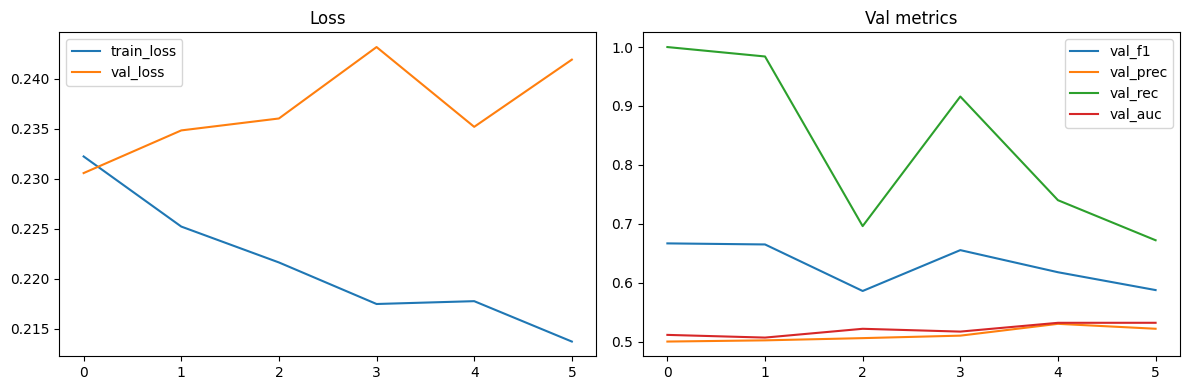

In [ ]:
model, history = train_model(model, train_loader, val_loader, epochs=15, patience=5)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'],   label='val_loss')
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(history['val_f1'],   label='val_f1')
plt.plot(history['val_prec'], label='val_prec')
plt.plot(history['val_rec'],  label='val_rec')
plt.plot(history['val_auc'],  label='val_auc')
plt.legend(); plt.title("Val metrics")
plt.tight_layout()
plt.show()
